# Кейс №1 - Приложение знакомств

## Принцип работы приложения
Механика приложения следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

## Нововведение:
Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

## Задача
Моя задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать одну или несколько метрик, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

# Загрузка и проверка данных

In [91]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy.stats
import pingouin as pg
import matplotlib.pyplot as plt

In [3]:
# загрузка данных
data = pd.read_csv('C:/Users/1/JupyterProjects/Karpov_courses_lessons_and_projects/module_statistics/all_data/dating_data.csv')

In [4]:
data.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id_1  14514 non-null  int64
 1   user_id_2  14514 non-null  int64
 2   group      14514 non-null  int64
 3   is_match   14514 non-null  int64
dtypes: int64(4)
memory usage: 453.7 KB


In [6]:
# проверка на наличие дубликатов
data[data.duplicated()].size

0

In [7]:
# изучим количественное соотношение групп
data.group.value_counts(normalize=True)

1    0.669836
0    0.330164
Name: group, dtype: float64

In [8]:
# уникальных пользователей в каждой группе
data.groupby('group').user_id_1.nunique()

group
0    501
1    499
Name: user_id_1, dtype: int64

In [9]:
data.groupby('group').user_id_2.nunique()

group
0    501
1    499
Name: user_id_2, dtype: int64

<AxesSubplot:xlabel='group', ylabel='count'>

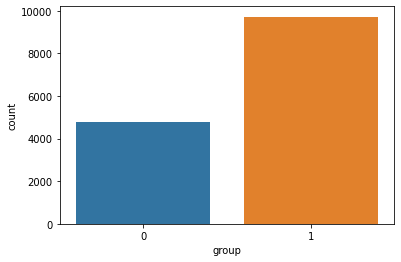

In [10]:
sns.barplot(data=data.groupby('group', as_index=False).agg(count=('is_match', 'count')), x='group', y='count')

In [11]:
# проверим, что каждый юзер пользовался приложением только с одним алгоритмом поиска (либо старым, либо новым)
print(data.groupby(['user_id_1'], as_index=False).group.nunique().query('group > 1').size)
print(data.groupby(['user_id_2'], as_index=False).group.nunique().query('group > 1').size)

0
0


In [12]:
# более простой способ через set
set_ctrl_1 = set(data.query('group == 0').user_id_1)
set_test_1 = set(data.query('group == 1').user_id_1)

set_ctrl_1.intersection(set_test_1)

set()

In [13]:
set_ctrl_2 = set(data.query('group == 0').user_id_2)
set_test_2 = set(data.query('group == 1').user_id_2)

set_ctrl_2.intersection(set_test_2)

set()

# Проверка гипотез
Сравним конверсии в "match" в двух группах:

## Гипотеза 1: Конверсия в группах различается

In [14]:
# конверсия в контрольной группе
data.query('group == 0').is_match.sum() * 100 / data.query('group == 0').shape[0]

19.490818030050082

In [15]:
# конверсия в тестовой группе
data.query('group == 1').is_match.sum() * 100 / data.query('group == 1').shape[0]

40.2077761777412

Так как мы работаем с двумя категориальными переменными: group и is_match, применим хи-квадрат Пирсона.

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [16]:
# составим таблицу сопряженности
cross_data = pd.crosstab(index=data['group'], columns=data['is_match'], aggfunc='count', values=data['is_match'])

In [17]:
cross_data

is_match,0,1
group,,
0,3858,934
1,5813,3909


In [18]:
# применим критерий
result = stats.chi2_contingency(cross_data)

In [19]:
result

Chi2ContingencyResult(statistic=618.6889141576198, pvalue=1.4418299163662586e-136, dof=1, expected_freq=array([[3193.01584677, 1598.98415323],
       [6477.98415323, 3244.01584677]]))

**Вывод**

Мы получили статзначимые различия(p-value < 0.05), значит мы отвергаем нулевую гипотезу о том, что взаимосвязи между переменными нет.

Итог: Конверсия в "match" в нашем приложении статзначимо увеличилась. Новый алгоритм поиска анкет работает лучше, чем старый. Его стоит развернуть на всю аудиторию пользователей.  

## Гипотеза 2: изменилось число анкет на пользователя

In [32]:
# число анкет на по группам для кадого из столбца user_id_1
size_per_user_1 = data.groupby(['group', 'user_id_1'], as_index=False).size()
size_per_user_1.head()

,group,user_id_1,size
0,0,4,9
1,0,10,6
2,0,12,12
3,0,14,8
4,0,15,20


In [33]:
# число анкет на по группам для кадого из столбца user_id_2
size_per_user_2 = data.groupby(['group', 'user_id_2'], as_index=False).size()
size_per_user_2.head()

,group,user_id_2,size
0,0,4,8
1,0,10,14
2,0,12,8
3,0,14,8
4,0,15,12


In [41]:
# произведем join таблиц по user_id и посчитаем сумму в по строкам size
size_per_user = size_per_user_1.merge(size_per_user_2, how='inner', right_on='user_id_2', left_on='user_id_1')

In [45]:
size_per_user['total_size'] = size_per_user.size_x + size_per_user.size_y

In [47]:
size_per_user.head()

,group_x,user_id_1,size_x,group_y,user_id_2,size_y,total_size
0,0,4,9,0,4,8,17
1,0,10,6,0,10,14,20
2,0,12,12,0,12,8,20
3,0,14,8,0,14,8,16
4,0,15,20,0,15,12,32


Проверка параметрических требований

In [49]:
control = size_per_user.query('group_x == 0')['total_size']
test = size_per_user.query('group_x == 1')['total_size']

Считаем выборки независимыми, так как нет одних и тех же пользователей в тесте и контроле

C:\Users\1\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\1\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_size', ylabel='Density'>

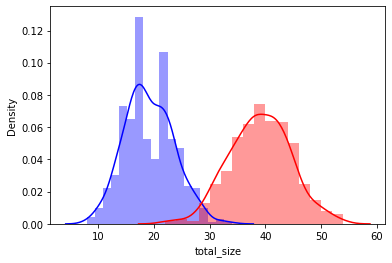

In [57]:
sns.distplot(control, color='blue')
sns.distplot(test, color='red')

In [63]:
# тест Шапиро на нормальность
scipy.stats.shapiro(control)

ShapiroResult(statistic=0.9900683760643005, pvalue=0.0018409064505249262)

In [58]:
scipy.stats.shapiro(test)

ShapiroResult(statistic=0.9948617219924927, pvalue=0.09492503851652145)

In [59]:
# стандартные отклонения
np.std(control)

4.422444764735976

In [60]:
np.std(test)

5.494471778398172

In [62]:
# применяем t-test
scipy.stats.ttest_ind(control, test)

Ttest_indResult(statistic=-62.837086115525075, pvalue=0.0)

**Вывод**

Среднее число анкет на пользователя статзначимо увеличилось в тесте.

## Гипотеза 3: изменилось число мэтчей на пользователя

Объединение и агрегация данных

In [68]:
match_1 = data.groupby(['group', 'user_id_1'], as_index=False).is_match.sum()

In [69]:
match_2 = data.groupby(['group', 'user_id_2'], as_index=False).is_match.sum()

In [71]:
match = match_1.merge(match_2, how='inner', left_on='user_id_1', right_on='user_id_2')

In [72]:
match['total_is_match'] = match.is_match_x + match.is_match_y

In [73]:
match.head()

,group_x,user_id_1,is_match_x,group_y,user_id_2,is_match_y,total_is_match
0,0,4,2,0,4,1,3
1,0,10,3,0,10,3,6
2,0,12,1,0,12,1,2
3,0,14,0,0,14,0,0
4,0,15,3,0,15,3,6


Проверка параметрических допущений

In [74]:
control = match.query('group_x == 0')['total_is_match']
test = match.query('group_x == 1')['total_is_match']

C:\Users\1\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\1\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_is_match', ylabel='Density'>

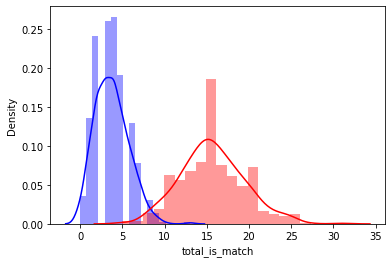

In [75]:
sns.distplot(control, color='blue')
sns.distplot(test, color='red')

In [76]:
scipy.stats.shapiro(control)

ShapiroResult(statistic=0.9586852788925171, pvalue=1.2164244611589936e-10)

In [77]:
scipy.stats.shapiro(test)

ShapiroResult(statistic=0.9886834025382996, pvalue=0.0006664181128144264)

In [78]:
np.std(control)

1.9885309055506355

In [79]:
np.std(test)

3.8422755331659872

Так как требования выполняются плохо, а размер выборок не так уж велик, применим тест Манна-Уитни

In [80]:
scipy.stats.mannwhitneyu(test, control)

MannwhitneyuResult(statistic=249409.0, pvalue=4.755813924800893e-164)

**Вывод**

Тест Манна-Уитни проверяет стохастическое равновесие. Он проверяет нулевую гипотезу о том, что распределения однородны. Мы получили p-value < 0.05, а значит наши распределения не однородны, число мэтчей на пользователя в тесте больше, чем в контроле

# Дополнительные способы проверки

## Тест Колмогорова-Смирнова

In [81]:
# довольно чувствительный тест, который также проверяет различие в распределениях
scipy.stats.ks_2samp(control, test)

KstestResult(statistic=0.9599758399033597, pvalue=2.3594701084592624e-258, statistic_location=8, statistic_sign=1)

## Тест Бруннера-Манцеля

In [84]:
# модифицированный вариант Манна-Уитни, проверяет стохастическое доминирование
scipy.stats.brunnermunzel(control, test)

BrunnerMunzelResult(statistic=536.7060827196013, pvalue=0.0)

## Bootstrap

In [85]:
scipy.stats.bootstrap([control, test], statistic=lambda x, y: np.median(x) - np.median(y))

C:\Users\1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_resampling.py:144: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\1\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


BootstrapResult(confidence_interval=ConfidenceInterval(low=nan, high=nan), bootstrap_distribution=array([-12., -11., -11., ..., -12., -11., -12.]), standard_error=0.6423882708719956)

Мы получили предупреждение, оно связано с тем, что в наших выборках слишком часто наблюдается разница в медианах размерм в 12, что исключает неуверенность в том, что это различие действительно является таковым (CI выродился в точку).

In [86]:
# сравним средние
scipy.stats.bootstrap([control, test], statistic=lambda x, y: np.mean(x) - np.mean(y))

BootstrapResult(confidence_interval=ConfidenceInterval(low=-12.312972099943645, high=-11.553095576862303), bootstrap_distribution=array([-11.95295581, -12.41549766, -11.9510958 , ..., -11.97652391,
       -11.93458374, -12.26545306]), standard_error=0.1934550543839451)

## Bootstrap и сравнение квантилей

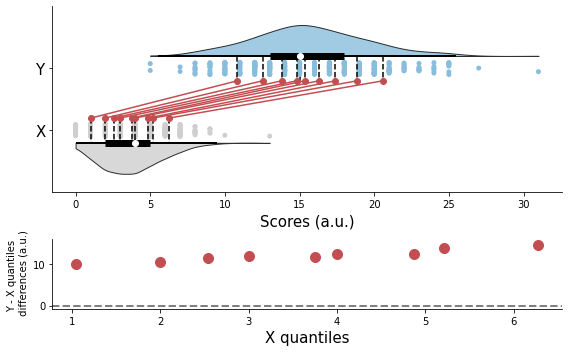

In [92]:
pg.plot_shift(control, test)

plt.show()

На первом графике мы наблюдаем то, что децили(0.1, 0.2,... квантили) сместились в большую сторону, так же одна точка на контроле соответствует нескольким на тесте, что означает увеличение разброса. Второй график показывает разность мужду квантилями для каждого квантиля

# Байесовский подход

In [20]:
!pip install numba --user

In [21]:
data.groupby('group', as_index=False).agg({'user_id_1': 'count', 'is_match': 'sum'}).rename(columns={'user_id_1': 'impressions', 'is_match': 'conversion'})

,group,impressions,conversion
0,0,4792,934
1,1,9722,3909


In [22]:
from math import lgamma
from numba import jit

#defining the functions used
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

In [23]:
from scipy.stats import beta
import numpy as np
#from calc_prob import calc_prob_between

#This is the known data: impressions and conversions for the Control and Test set
imps_ctrl,convs_ctrl=4792, 934 
imps_test, convs_test=9722, 3909

#here we create the Beta functions for the two sets
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
beta_C = beta(a_C, b_C)
a_T, b_T = convs_test+1, imps_test-convs_test+1
beta_T = beta(a_T, b_T)

#calculating the lift
lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

#calculating the probability for Test to be better than Control
prob=calc_prob_between(beta_T, beta_C)

print (f"Test option lift Conversion Rates by {lift*100:2.2f}% with {prob*100:2.1f}% probability.")

Test option lift Conversion Rates by 106.17% with 100.0% probability.
